Dataset: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
!mkdir -p /content/drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path_test = "/content/drive/MyDrive/FaceMask_dataset/Test"
path_train = "/content/drive/MyDrive/FaceMask_dataset/Train"
path_validation = "/content/drive/MyDrive/FaceMask_dataset/Validation"

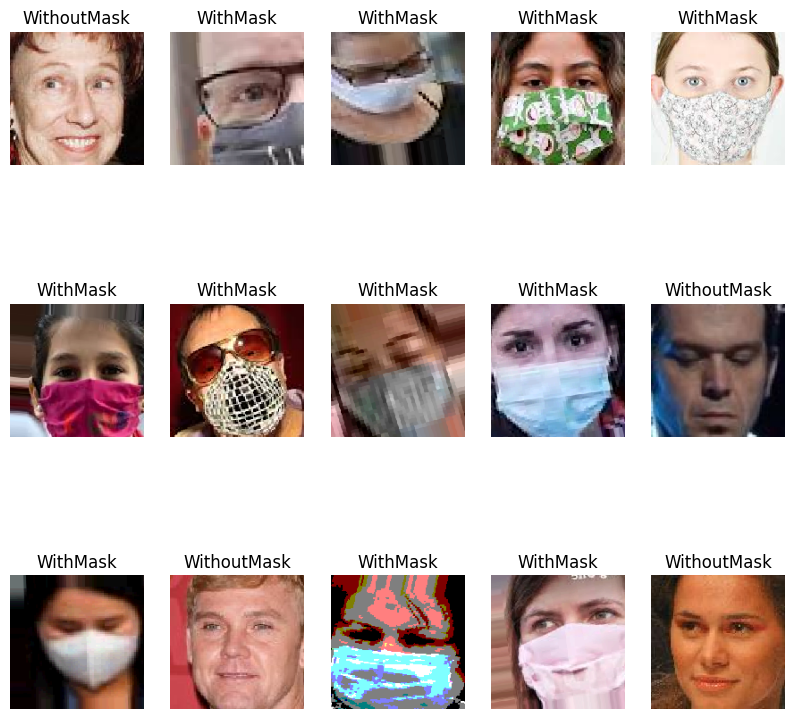

In [5]:
data_train = image_dataset_from_directory(path_train,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
classes_train = data_train.class_names
plt.figure(figsize=(10,10))
for img, label in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')

clear_output()

In [6]:
classes = next(os.walk(path_train))[1]
print(classes)

['WithoutMask', 'WithMask']


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
IMG_SIZE = (256, 256)

train_dataset = train_datagen.flow_from_directory(path_train, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(path_test, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(path_validation, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 10009 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [15]:
inceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in inceptionV3.layers:
    layer.trainable = False

In [16]:
model = Sequential()
model.add(inceptionV3)

model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))    #two classes

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
callback = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.00001,
    patience=3,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
    )

In [18]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [19]:
inception_history = model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs=1,
                        verbose=1,
                        callbacks=callback)

51/51 [==============================] - 2932s 57s/step - loss: 1.2383 - accuracy: 0.9147 - val_loss: 0.1818 - val_accuracy: 0.9762


In [20]:
inception_accuracy = model.evaluate(test_dataset)

16/16 [==============================] - 255s 17s/step - loss: 0.0718 - accuracy: 0.9940


In [24]:
model.save("./inceptionV3.h5")